<a href="https://colab.research.google.com/github/ticklecatisback/My-colab-Collections/blob/main/Wav2Lip_HQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wav2Lip-HQ

This notebook is a demo describing Wav2Lip-HQ model for lip-sync of high quality videos.

* Github: https://github.com/Markfryazino/wav2lip-hq
* Paper: https://arxiv.org/abs/2008.10010
* Original notebook: https://colab.research.google.com/drive/1bwgV-31JLNFTKCVDnJtTbP4brOUV1xaL?usp=sharing

## At first, clone the repository and load all required models.

In [1]:
#@title <h1>Step1: Setup Wav2Lip</h1>
#@markdown * Install dependency
#@markdown * Download pretrained model
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/sudo-ken/FFmpeg-for-GDrive/master/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")
 
from ttmg import (
    loadingAn,
    textAn,
)
 
loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')

os.system('git clone https://github.com/Markfryazino/wav2lip-hq.git')
%cd wav2lip-hq
os.system('pip3 install gdown')
os.system('pip3 install -r requirements.txt')
os.system('pip install -q youtube-dl')
os.system('pip install ffmpeg-python')
os.system('pip install https://raw.githubusercontent.com/AwaleSajil/ghc/master/ghc-1.0-py3-none-any.whl')

os.system('wget "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" -O "face_detection/detection/sfd/s3fd.pth"')

import gdown

urls = {
    "wav2lip_gan.pth": "10Iu05Modfti3pDbxCFPnofmfVlbkvrCm", 
    "face_segmentation.pth": "154JgKpzCPW82qINcVieuPH3fZ2e0P812",
    "esrgan_max.pth": "1e5LT83YckB5wFKXWV4cWOPkVRnCDmvwQ",
    "esrgan_yunying.pth": "1aB-jqBikcZPJnFrJXWUEpvF2RFCuerSe",
    "pretrained.state": "1_MGeOLdARWHylC1PCU2p5_FQztD4Bo7B"
}

for name, id in urls.items():
    url = f"https://drive.google.com/uc?id={id}"
    output = f"checkpoints/{name}"
    gdown.download(url, output, quiet=False)
    print(f"Loaded {name}")

#this code for recording audio
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

%cd /
from ghc.l_ghc_cf import l_ghc_cf
%cd content

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr


from IPython.display import HTML
from base64 import b64encode
def showVideo(path):
  mp4 = open(str(path),'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=700 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

from IPython.display import clear_output

/content/wav2lip-hq


Downloading...
From: https://drive.google.com/uc?id=10Iu05Modfti3pDbxCFPnofmfVlbkvrCm
To: /content/wav2lip-hq/checkpoints/wav2lip_gan.pth
100%|██████████| 436M/436M [00:07<00:00, 59.4MB/s]


Loaded wav2lip_gan.pth


Downloading...
From: https://drive.google.com/uc?id=154JgKpzCPW82qINcVieuPH3fZ2e0P812
To: /content/wav2lip-hq/checkpoints/face_segmentation.pth
100%|██████████| 53.3M/53.3M [00:00<00:00, 195MB/s]


Loaded face_segmentation.pth


Downloading...
From: https://drive.google.com/uc?id=1e5LT83YckB5wFKXWV4cWOPkVRnCDmvwQ
To: /content/wav2lip-hq/checkpoints/esrgan_max.pth
100%|██████████| 67.0M/67.0M [00:00<00:00, 120MB/s]


Loaded esrgan_max.pth


Downloading...
From: https://drive.google.com/uc?id=1aB-jqBikcZPJnFrJXWUEpvF2RFCuerSe
To: /content/wav2lip-hq/checkpoints/esrgan_yunying.pth
100%|██████████| 67.0M/67.0M [00:00<00:00, 197MB/s]


Loaded esrgan_yunying.pth


Downloading...
From: https://drive.google.com/uc?id=1_MGeOLdARWHylC1PCU2p5_FQztD4Bo7B
To: /content/wav2lip-hq/checkpoints/pretrained.state
100%|██████████| 311M/311M [00:01<00:00, 163MB/s]


Loaded pretrained.state
/
/content


## Now upload target audio and video.

You can just upload via Google Colab interface

In [ ]:
#@title <b><font color="red"> (DO NOT RUN)
#@markdown <b><font color="red"> ONLY FOR TESTING
# If you load files from Drive, run this cell

# Paste your filenames and Google Drive IDs below.
urls = {
    "shulman_30s.mp4": "1bkvqn_tW6lDDjCLatPkT7XlXm9zFDdQl",
    "yunying_30s.mp4": "1dggydm07RHrxiFUIH_51RXmkMcD_bMPE",
}

for name, id in urls.items():
    url = f"https://drive.google.com/uc?id={id}"
    output = f"videos/{name}"
    gdown.download(url, output, quiet=False)
    print(f"Loaded {name}")

In [ ]:
#@title STEP2: Select a Youtube Video
video_url = 'https://www.youtube.com/watch?v=vAnWYLTdvfY' #@param {type:"string"}

import shutil

import os
import os.path
from IPython.display import clear_output
import youtube_dl

loadingAn(name="lds")
textAn("Downloading Video...", ty='twg')
if video_url:
  !rm -f /content/wav2lip-hq/videos/youtube.mp4
  !youtube-dl -f "bestvideo[ext=mp4][vcodec!*=av01][height<=360]+bestaudio[ext=m4a]/mp4[height<=360][vcodec!*=av01]/mp4[vcodec!*=av01]/mp4" "$video_url" --merge-output-format mp4 -o /content/wav2lip-hq/videos/youtube.mp4

# cut the video
textAn("Trimming Video...", ty='twg')

start_seconds = 0 #@param {type:"number"}
duration_seconds =  60#@param {type:"number"}
start_seconds = max(start_seconds,0)
duration_seconds = max(duration_seconds,0)

if duration_seconds:
  !mv /content/wav2lip-hq/videos/youtube.mp4 /content/full_video.mp4
  !ffmpeg -ss $start_seconds -t $duration_seconds -i /content/full_video.mp4 -f mp4 /content/wav2lip-hq/videos/youtube.mp4 -y

!rm -df youtube.mp4
# download the youtube with the given ID

#delete video.mp4 if already exits
!rm -f /content/wav2lip-hq/videos/ass.mp4


#Preview trimmed video
clear_output()
print("Trimmed Video")
showVideo('/content/wav2lip-hq/videos/youtube.mp4')

In [ ]:
#@title STEP3: Select Audio (Record or Upload)
from IPython.display import Audio 
from IPython.core.display import display
import shutil
import os, sys, re
record_or_upload = 'Upload' #@param ['Record', 'Upload']

def displayAudio():
  display(Audio('/content/wav2lip-hq/videos/input_audioconverted.wav'))
if record_or_upload == 'Record':
  audio, sr = get_audio()
  import scipy
  scipy.io.wavfile.write('/content/wav2lip-hq/videos/input_audioaudioconverted.wav', sr, audio)
  clear_output()
  displayAudio()
  # stop
  print("Ignore the error it will be fix soon.")
  !sudo mpirun --allow-run-as-root -n lmp_stable -sf gpu -pk gpu 1 neigh no newton off -in LAMMPS_inp
elif record_or_upload == 'Upload':
  from google.colab import files
  uploaded = files.upload()
  dst ='input_audio.mp3' 
  os.rename(list(uploaded.keys())[0], dst)
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.move("/content/input_audio.mp3", "/content/wav2lip-hq/videos")

loadingAn(name="lds")
textAn("Converting Audio...", ty='twg')

audio_file_path = "/content/wav2lip-hq/videos/input_audio.mp3"
output_file_type = "wav"

output_file_path = re.search("^[\/].+\/", audio_file_path)
output_file_path_raw = output_file_path.group(0)
delsplit = re.search("\/(?:.(?!\/))+$", audio_file_path)
filename = re.sub("^[\/]", "", delsplit.group(0))
filename_raw = re.sub(".{4}$", "", filename)
file_extension = re.search(".{3}$", filename)
file_extension_raw = file_extension.group(0)

os.environ['inputFile'] = audio_file_path
os.environ['outputPath'] = output_file_path_raw
os.environ['fileExtension'] = output_file_type
os.environ['fileName'] = filename_raw

os.system('ffmpeg -hide_banner -i "$inputFile" "$outputPath"/"$fileName"converted."$fileExtension"')

#concider only the first file
audio_file = str(list(uploaded.keys())[0])
!rm -f '/content/wav2lip-hq/videos/input_audio.mp3'
!ffmpeg -i '$audio_file' '/content/wav2lip-hq/videos/input_audioconverted.wav'

input_audio = "/content/wav2lip-hq/videos/input_audioconverted.wav"

s = 1

if s == 1:
  display(Audio(input_audio, autoplay=True))


In [ ]:
#@title Delete old input audio file
%rm /content/wav2lip-hq/videos/input_audioconverted.wav
from IPython.display import clear_output 
clear_output()

In [ ]:
#@title <b><font color="red"> (DO NOT RUN)
#@markdown <b><font color="red"> ONLY FOR TESTING
from IPython.display import Audio, display
from IPython.core.display import display
import time
import sys
import shutil

record_or_upload = 'Record' #@param ['Record', 'Upload']

SAMPLE_RATE = 44100
record_seconds = 10#@param {type:"number"}

stream = await navigator.mediaDevices.getUserMedia({ audio: true })
recorder = new MediaRecorder(stream)
chunks = []
recorder.ondataavailable = e => chunks.push(e.data)

if record_or_upload == 'Upload':
  from google.colab import files
  uploaded = files.upload()
  dst ='input_audio.mp3' 
  os.rename(list(uploaded.keys())[0], dst)
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
#concider only the this file
shutil.move("/content/input_audio.mp3", "/content/wav2lip-hq/videos")

loadingAn(name="lds")
textAn("Converting Audio...", ty='twg')

audio_file_path = "/content/wav2lip-hq/videos/input_audio.mp3"
output_file_type = "wav"

output_file_path = re.search("^[\/].+\/", audio_file_path)
output_file_path_raw = output_file_path.group(0)
delsplit = re.search("\/(?:.(?!\/))+$", audio_file_path)
filename = re.sub("^[\/]", "", delsplit.group(0))
filename_raw = re.sub(".{4}$", "", filename)
file_extension = re.search(".{3}$", filename)
file_extension_raw = file_extension.group(0)

os.environ['inputFile'] = audio_file_path
os.environ['outputPath'] = output_file_path_raw
os.environ['fileExtension'] = output_file_type
os.environ['fileName'] = filename_raw

os.system('ffmpeg -hide_banner -i "$inputFile" "$outputPath"/"$fileName"converted."$fileExtension"')

#concider only the first file
audio_file = str(list(uploaded.keys())[0])
!rm -f '/content/wav2lip-hq/videos/input_audio.wav'
!ffmpeg -i '$audio_file' '/content/wav2lip-hq/videos/input_audio.wav'

input_audio = "/content/wav2lip-hq/videos/input_audioconverted.wav"

s = 1

if s == 1:
  display(Audio(input_audio, autoplay=True))


## Finally, run the model!

Also, you may want to change `--sr-path` if you've pretrained the super resolution model.

In [ ]:
#@title <b><font color="red"> (DO NOT RUN)
#@markdown <b><font color="red"> ONLY FOR TESTING
!python inference.py \
        --checkpoint_path "checkpoints/wav2lip_gan.pth" \
        --segmentation_path "checkpoints/face_segmentation.pth" \
        --sr_path "checkpoints/esrgan_max.pth" \
        --face "videos/yunying_30s.mp4" \
        --audio "videos/shulman_30s.mp4" \
        --outfile "results/shulman_to_yunying.mp4"

In [ ]:
#@title STEP4: Start Crunching and Preview Output
#@markdown <b>Note: Only change these, if you have to</b>
pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
sr_path = 'checkpoints/esrgan_max.pth' #@param {type:"string"}
nosmooth = False #@param {type:"boolean"}


loadingAn(name="lds")
textAn("Analyzing Video...", ty='twg')

if nosmooth == False:
  !cd wav2lip-hq && python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --segmentation_path checkpoints/face_segmentation.pth --sr_path checkpoints/esrgan_max.pth --face "/content/wav2lip-hq/videos/youtube.mp4" --audio "/content/wav2lip-hq/videos/input_audioconverted.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !cd wav2lip-hq && python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --segmentation_path checkpoints/face_segmentation.pth --sr_path $sr_path --face "/content/wav2lip-hq/videos/youtube.mp4" --audio "/content/wav2lip-hq/videos/input_audioconverted.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
clear_output()
print("Final Video Preview")
print("Dowload this video from", '/content/wav2lip-hq/results/result_voice.mp4')
showVideo('/content/wav2lip-hq/results/result_voice.mp4')

In [ ]:
#@title You might get better results by running this cell
pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
nosmooth = False #@param {type:"boolean"}

loadingAn(name="lds")
textAn("Analyzing Video...", ty='twg')

if nosmooth == False:
!cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth"  --segmentation_path "checkpoints/face_segmentation.pth"  --sr_path "checkpoints/esrgan_yunying.pth" --face "/content/wav2lip-hq/videos/youtube.mp4"  --audio "/content/wav2lip-hq/videos/input_audioconverted.wav"  --save_frames  --gt_path "data/gt"  --pred_path "data/lq"  --no_sr --no_segmentation --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth" --segmentation_path "checkpoints/face_segmentation.pth" --sr_path --face "/content/wav2lip-hq/videos/youtube.mp4" --audio "/content/wav2lip-hq/videos/input_audioconverted.wav" --save_frames  --gt_path "data/gt"  --pred_path "data/lq"  --no_sr --no_segmentation --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
clear_output()
print("Final Video Preview")
print("Dowload this video from", '/content/wav2lip-hq/results/result_voice.mp4')
showVideo('/content/wav2lip-hq/results/result_voice.mp4')

In [ ]:
#@title Download Video
#@markdown 1. If it fails try running this cell again.
#@markdown 2. Alternatively, you can manually download "output.mp4", "combined.mp4" from the folder on the left (click "Refresh" if missing).

print() #see https://github.com/googlecolab/colabtools/issues/468
from google.colab import files
files.download('/content/wav2lip-hq/results/result_voice.mp4') #fails for Firefox private window

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Delete old result file
%rm /content/wav2lip-hq/results/result_voice.mp4
from IPython.display import clear_output 
clear_output()

# LipSync on Your Video File

In [ ]:
#@title STEP2: Upload your Video File
from google.colab import files
uploaded = files.upload()
dst ='input_vid.mp4' 
os.rename(list(uploaded.keys())[0], dst)

loadingAn(name="lds")
textAn("Moving Video...", ty='twg')

PATH_TO_YOU_VIDEO = '/content/input_vid.mp4'
import os, sys, re
import subprocess

shutil.move("/content/input_vid.mp4", "/content/wav2lip-hq/videos") 

#@markdown ### Trim the video (start, end) seconds
#@markdown <i>Don't want to trim ? put <b>'start'</b> = -1 and <b>'end'</b> = -1</i>
start =  -1#@param {type:"integer"}
end =  -1#@param {type:"integer"}


#@markdown <i>Note: the trimmed video must have face on all frames</i>

# delete start end
interval = end - start

textAn("Triming Video...", ty='twg')

#delete if file already exists
!rm -f '/content/input.vid.mp4'

if start < 0 or end < 0:
  #convert the video to specif location
  !ffmpeg -i '$PATH_TO_YOU_VIDEO' '/content/wav2lip-hq/videos/input_vid.mp4'
else:
  # cut the video
  !ffmpeg -i '$PATH_TO_YOU_VIDEO' -ss {start} -t {interval} -async 1 '/content/wav2lip-hq/videos/input_vid.mp4'
from IPython.display import clear_output

# Preview trimmed video
clear_output()
print("Input Video")
showVideo('/content/wav2lip-hq/videos/input_vid.mp4')

In [ ]:
#@title Delete old input Video file
%rm /content/wav2lip-hq/videos/input_vid.mp4
from IPython.display import clear_output 
clear_output()

In [ ]:
#@title STEP3: Select Audio (Record or Upload)
from IPython.display import Audio 
from IPython.core.display import display
import shutil
import os, sys, re
record_or_upload = 'Record' #@param ['Record', 'Upload']

def displayAudio():
  display(Audio('/content/wav2lip-hq/videos/input_audio_sec.wav'))
if record_or_upload == 'Record':
  audio, sr = get_audio()
  import scipy
  scipy.io.wavfile.write('/content/wav2lip-hq/videos/input_audio_sec.wav', sr, audio)
  clear_output()
  displayAudio()
  # stop
  print("Ignore the error it will be fix soon.")
  !sudo mpirun --allow-run-as-root -n lmp_stable -sf gpu -pk gpu 1 neigh no newton off -in LAMMPS_inp
elif record_or_upload == 'Upload':
  from google.colab import files
  uploaded = files.upload()
  dst ='input_audio_sec.mp3' 
  os.rename(list(uploaded.keys())[0], dst)
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.move("/content/input_audio_sec.mp3", "/content/wav2lip-hq/videos")

loadingAn(name="lds")
textAn("Converting Audio...", ty='twg')

audio_file_path = "/content/wav2lip-hq/videos/input_audio_sec.mp3"
output_file_type = "wav"

output_file_path = re.search("^[\/].+\/", audio_file_path)
output_file_path_raw = output_file_path.group(0)
delsplit = re.search("\/(?:.(?!\/))+$", audio_file_path)
filename = re.sub("^[\/]", "", delsplit.group(0))
filename_raw = re.sub(".{4}$", "", filename)
file_extension = re.search(".{3}$", filename)
file_extension_raw = file_extension.group(0)

os.environ['inputFile'] = audio_file_path
os.environ['outputPath'] = output_file_path_raw
os.environ['fileExtension'] = output_file_type
os.environ['fileName'] = filename_raw

os.system('ffmpeg -hide_banner -i "$inputFile" "$outputPath"/"$fileName"convert."$fileExtension"')

#concider only the first file
audio_file = str(list(uploaded.keys())[0])
!rm -f '/content/wav2lip-hq/videos/input_audio_sec.mp3'
!ffmpeg -i '$audio_file' '/content/wav2lip-hq/videos/input_audioconvert.wav'

input_audio = "/content/wav2lip-hq/videos/input_audioconvert.wav"

s = 1

if s == 1:
  display(Audio(input_audio, autoplay=True))


In [ ]:
#@title Delete old input audio file
%rm /content/wav2lip-hq/videos/input_audioconvert.wav
from IPython.display import clear_output 
clear_output()

In [ ]:
#@title STEP4: Start Crunching and Preview Output
#@markdown <b>Note: Only change these, if you have to</b>
pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
sr_path = 'checkpoints/esrgan_max.pth' #@param {type:"string"}
nosmooth = False #@param {type: "boolean"}


loadingAn(name="lds")
textAn("Analyzing Video...", ty='twg')

if nosmooth == False:
  !cd wav2lip-hq && python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --segmentation_path checkpoints/face_segmentation.pth --sr_path checkpoints/esrgan_max.pth --face "/content/wav2lip-hq/videos/input_vid.mp4" --audio "/content/wav2lip-hq/videos/input_audioconverted.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !cd wav2lip-hq && pyt hon inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --segmentation_path checkpoints/face_segmentation.pth --sr_path $sr_path --face "/content/wav2lip-hq/videos/input_vid.mp4" --audio "/content/wav2lip-hq/videos/input_audioconverted.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
clear_output()
print("Final Video Preview")
print("Dowload this video from", '/content/wav2lip-hq/results/result_voice.mp4')
showVideo('/content/wav2lip-hq/results/result_voice.mp4')

In [ ]:
#@title You might get better results by running this cell
pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
nosmooth = False #@param {type: "boolean"}

loadingAn(name="lds")
textAn("Analyzing Video...", ty='twg')

if nosmooth == False:
!cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth"  --segmentation_path "checkpoints/face_segmentation.pth"  --sr_path "checkpoints/esrgan_yunying.pth" --face "/content/wav2lip-hq/videos/input_vid.mp4"  --audio "/content/wav2lip-hq/videos/input_audioconverted.wav"  --save_frames  --gt_path "data/gt"  --pred_path "data/lq"  --no_sr --no_segmentation --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth" --segmentation_path "checkpoints/face_segmentation.pth" --sr_path $sr_path --face "/content/wav2lip-hq/videos/input_vid.mp4" --audio "/content/wav2lip-hq/videos/input_audioconverted.wav" --save_frames  --gt_path "data/gt"  --pred_path "data/lq"  --no_sr --no_segmentation --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
clear_output()
print("Final Video Preview")
print("Dowload this video from", '/content/wav2lip-hq/results/result_voice.mp4')
showVideo('/content/wav2lip-hq/results/result_voice.mp4')

In [ ]:
#@title Download Video
#@markdown 1. If it fails try running this cell again.
#@markdown 2. Alternatively, you can manually download "output.mp4", "combined.mp4" from the folder on the left (click "Refresh" if missing).

print() #see https://github.com/googlecolab/colabtools/issues/468
from google.colab import files
files.download('/content/wav2lip-hq/results/result_voice.mp4') #fails for Firefox private window

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Delete old result file
%rm /content/wav2lip-hq/results/result_voice.mp4
from IPython.display import clear_output 
clear_output()

# LipSync on Your Image File

--2022-10-24 19:02:53--  https://media.bizj.us/view/img/11965652/glennfukuda-4196c-pr*1500xx1819-2425-61-0.jpg
Resolving media.bizj.us (media.bizj.us)... 65.9.86.80, 65.9.86.124, 65.9.86.43, ...
Connecting to media.bizj.us (media.bizj.us)|65.9.86.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 354485 (346K) [image/jpeg]
Saving to: ‘/content/wav2lip-hq/images/image.png’

/content/wav2lip-hq 100%[===================>] 346.18K   539KB/s    in 0.6s    

2022-10-24 19:02:54 (539 KB/s) - ‘/content/wav2lip-hq/images/image.png’ saved [354485/354485]



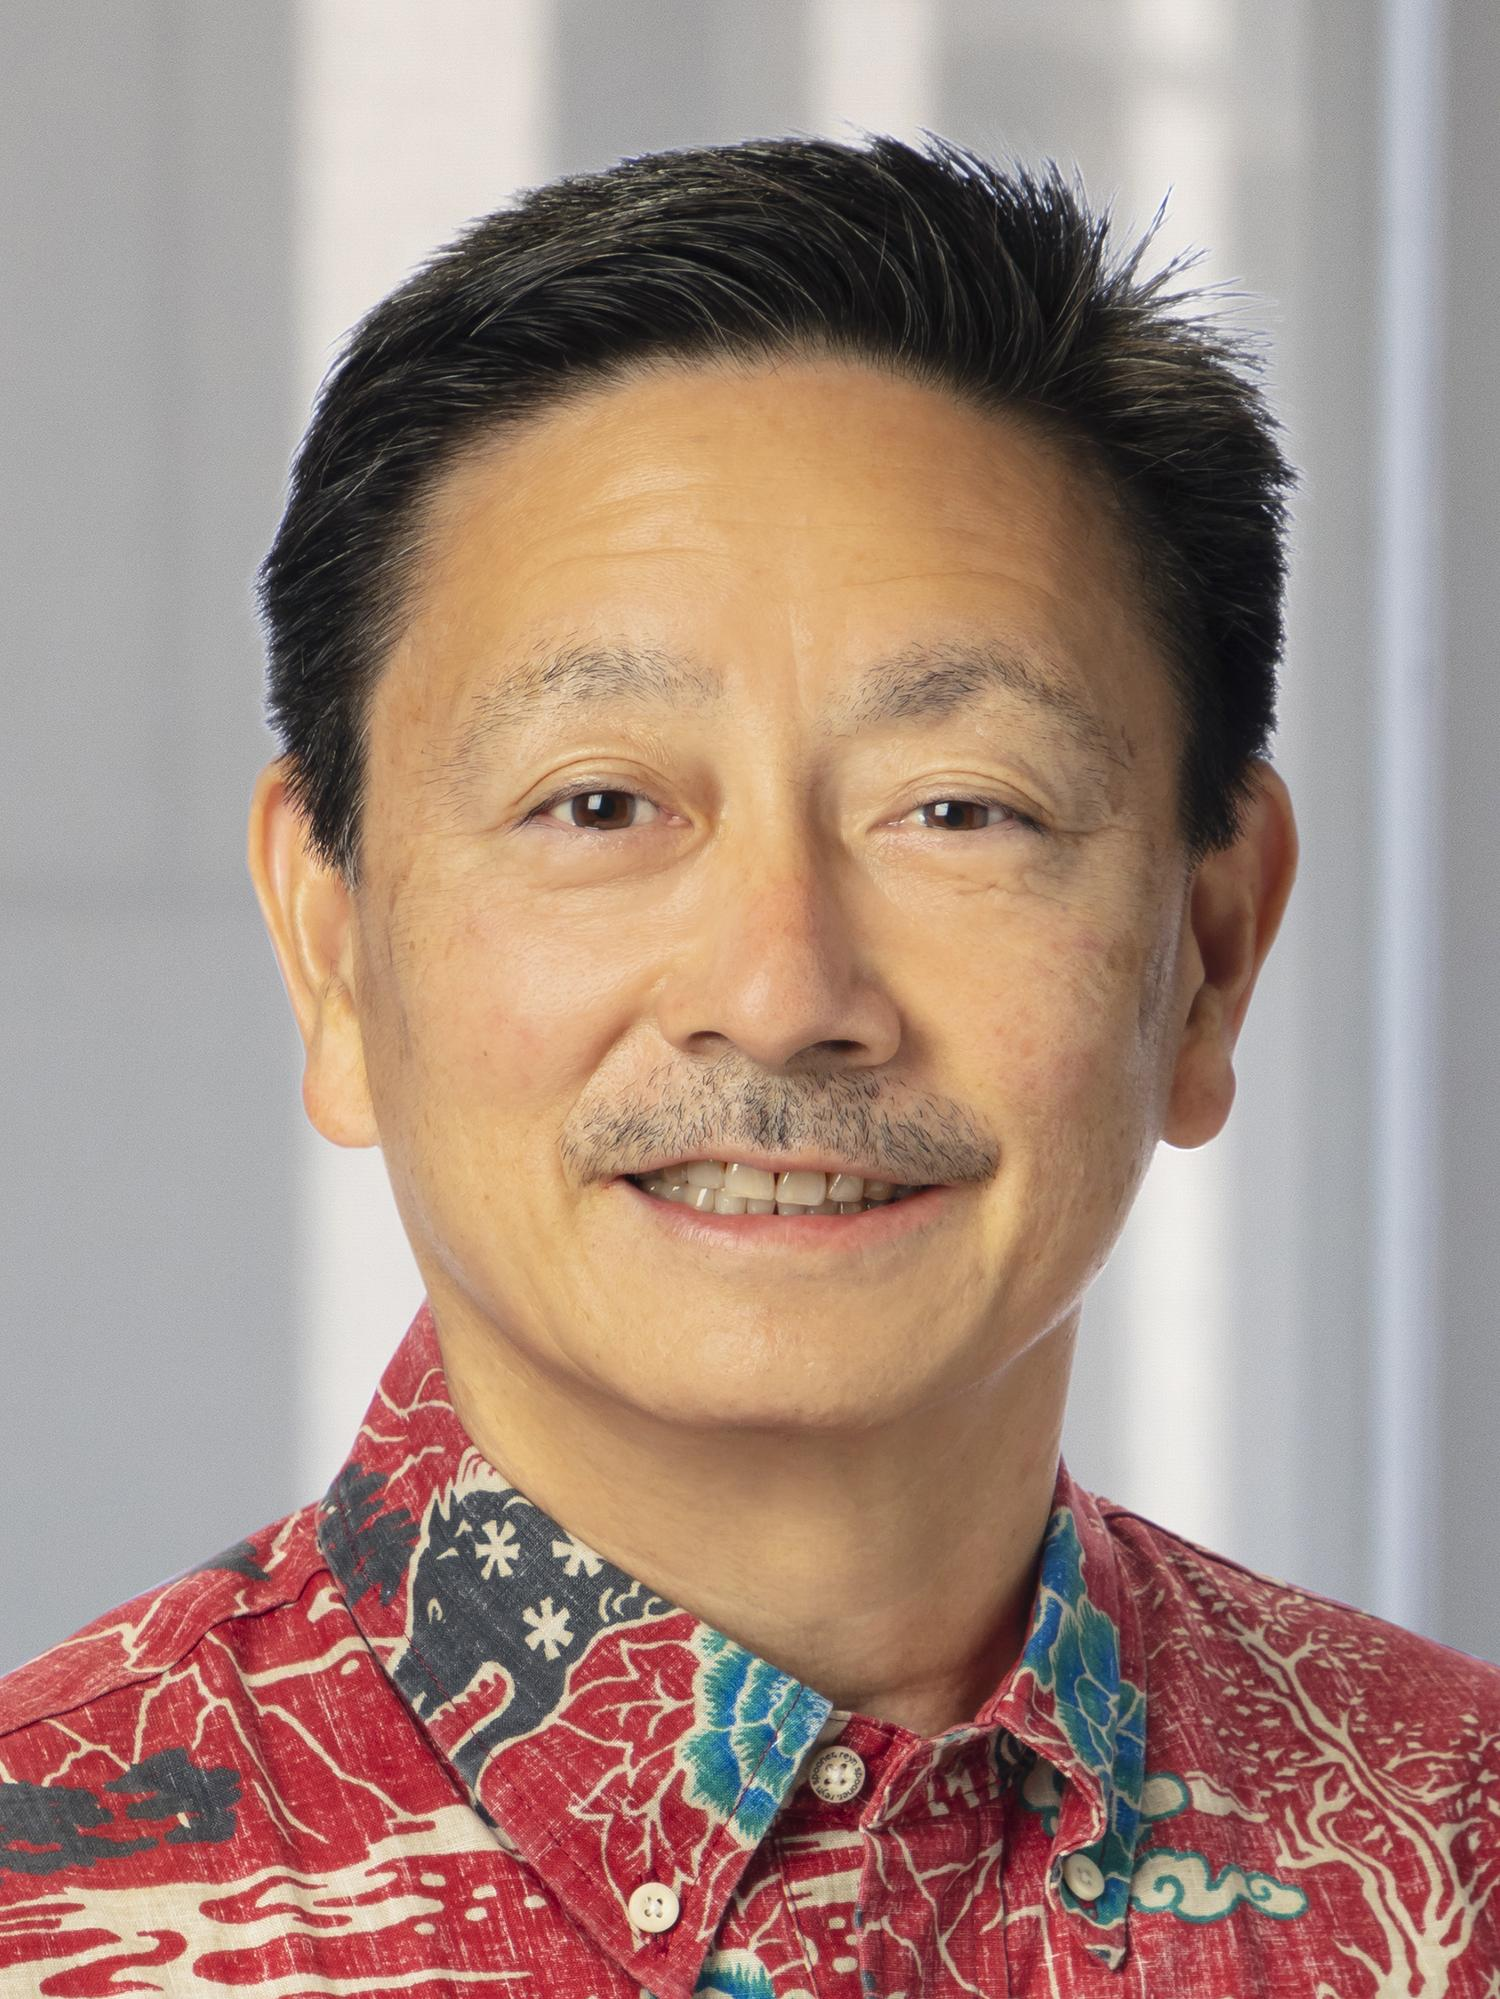

In [2]:
#@title STEP2: Select a Image
image_url = 'https://media.bizj.us/view/img/11965652/glennfukuda-4196c-pr*1500xx1819-2425-61-0.jpg' #@param {type:"string"}
import shutil
import cv2
from IPython.display import Image

if image_url:
  !wget "$image_url" -O /content/wav2lip-hq/images/image.png

Image('/content/wav2lip-hq/images/image.png')

In [ ]:
#@title STEP2+: Upload your Image
import os
from google.colab import files
import cv2
import shutil
from IPython.display import Image
uploaded = files.upload()
dst ='image.png' 
os.rename(list(uploaded.keys())[0], dst)
shutil.move("/content/image.png", "/content/wav2lip-hq/images")

Image('/content/wav2lip-hq/images/image.png')

In [ ]:
#@title Delete old input Image file
%rm /content/wav2lip-hq/images/image.png
from IPython.display import clear_output 
clear_output()

In [3]:
#@title STEP3: Select Audio (Record or Upload)
from IPython.display import Audio 
from IPython.core.display import display
import shutil
import os, sys, re
record_or_upload = 'Upload' #@param ['Record', 'Upload']

def displayAudio():
  display(Audio('/content/wav2lip-hq/videos/input_audio_img.wav'))
if record_or_upload == 'Record':
  audio, sr = get_audio()
  import scipy
  scipy.io.wavfile.write('/content/wav2lip-hq/videos/input_audio_img.wav', sr, audio)
  clear_output()
  displayAudio()
  # stop
  print("Ignore the error it will be fix soon.")
  !sudo mpirun --allow-run-as-root -n lmp_stable -sf gpu -pk gpu 1 neigh no newton off -in LAMMPS_inp
elif record_or_upload == 'Upload':
  from google.colab import files
  uploaded = files.upload()
  dst ='input_audio_image.mp3' 
  os.rename(list(uploaded.keys())[0], dst)
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.move("/content/input_audio_image.mp3", "/content/wav2lip-hq/videos")

loadingAn(name="lds")
textAn("Converting Audio...", ty='twg')

audio_file_path = "/content/wav2lip-hq/videos/input_audio_image.mp3"
output_file_type = "wav"

output_file_path = re.search("^[\/].+\/", audio_file_path)
output_file_path_raw = output_file_path.group(0)
delsplit = re.search("\/(?:.(?!\/))+$", audio_file_path)
filename = re.sub("^[\/]", "", delsplit.group(0))
filename_raw = re.sub(".{4}$", "", filename)
file_extension = re.search(".{3}$", filename)
file_extension_raw = file_extension.group(0)

os.environ['inputFile'] = audio_file_path
os.environ['outputPath'] = output_file_path_raw
os.environ['fileExtension'] = output_file_type
os.environ['fileName'] = filename_raw

os.system('ffmpeg -hide_banner -i "$inputFile" "$outputPath"/"$fileName"converting."$fileExtension"')

#concider only the first file
audio_file = str(list(uploaded.keys())[0])
!rm -f '/content/wav2lip-hq/videos/input_audio_image.mp3'
!ffmpeg -i '$audio_file' '/content/wav2lip-hq/videos/input_audio_imageconverting.wav'

input_audioconverting = "/content/wav2lip-hq/videos/input_audio_imageconverting.wav"

s = 1

if s == 1:
  display(Audio(input_audioconverting, autoplay=True))


Saving bazigar_part1.wav to bazigar_part1.wav
User uploaded file "bazigar_part1.wav" with length 1421390 bytes


ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
#@title Delete old input audio file
%rm /content/wav2lip-hq/videos/input_audio_imageconverting.wav
from IPython.display import clear_output 
clear_output()

In [ ]:
#@title Optional: The snippet to resize ground truth images to 384  ×  384 resolution.
import os

paths = os.listdir("data/gt")

for img_path in tqdm(paths):
    img = cv2.imread("data/gt/" + img_path)
    img = cv2.resize(img, (384, 384))
    cv2.imwrite("data/hq/" + img_path, img)

In [6]:
#@title STEP4: Start Crunching and Preview Output
#@markdown <b>Note: Only change these, if you have to</b>
pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
sr_path = 'checkpoints/esrgan_max.pth' #@param {type:"string"}
nosmooth = False #@param {type:"boolean"}


loadingAn(name="lds")
textAn("Analyzing Video...", ty='twg')

if nosmooth == False:
  !cd wav2lip-hq && python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --segmentation_path checkpoints/face_segmentation.pth --sr_path checkpoints/esrgan_max.pth --face "/content/wav2lip-hq/images/image.png" --audio "/content/wav2lip-hq/videos/input_audio_imageconverting.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth" --segmentation_path "checkpoints/face_segmentation.pth" --sr_path $sr_path --face "/content/wav2lip-hq/images/image.png" --audio "/content/wav2lip-hq/videos/input_audio_imageconverting.wav" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
clear_output()
print("Final Video Preview")
print("Dowload this video from", '/content/wav2lip-hq/results/result_voice.mp4')
showVideo('/content/wav2lip-hq/results/result_voice.mp4')

Final Video Preview
Dowload this video from /content/wav2lip-hq/results/result_voice.mp4


In [ ]:
#@title You might get better results by running this cell
pad_top =  0#@param {type:"integer"}
pad_bottom =  10#@param {type:"integer"}
pad_left =  0#@param {type:"integer"}
pad_right =  0#@param {type:"integer"}
rescaleFactor =  1#@param {type:"integer"}
nosmooth = False #@param {type:"boolean"}

loadingAn(name="lds")
textAn("Analyzing Video...", ty='twg')

if nosmooth == False:
!cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth"  --segmentation_path "checkpoints/face_segmentation.pth"  --sr_path "checkpoints/esrgan_yunying.pth" --face "/content/wav2lip-hq/images/image.png"  --audio "/content/wav2lip-hq/videos/input_audio_imageconverting.wav"  --save_frames  --gt_path "data/gt"  --pred_path "data/lq"  --no_sr --no_segmentation --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
else:
  !cd wav2lip-hq && python inference.py --checkpoint_path "checkpoints/wav2lip_gan.pth" --segmentation_path "checkpoints/face_segmentation.pth" --sr_path --face "/content/wav2lip-hq/images/image.png" --audio "/content/wav2lip-hq/videos/input_audio_imageconverting.wav" --save_frames  --gt_path "data/gt"  --pred_path "data/lq"  --no_sr --no_segmentation --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

#Preview output video
clear_output()
print("Final Video Preview")
print("Dowload this video from", '/content/wav2lip-hq/results/result_voice.mp4')
showVideo('/content/wav2lip-hq/results/result_voice.mp4')

In [ ]:
#@title Download Video
#@markdown 1. If it fails try running this cell again.
#@markdown 2. Alternatively, you can manually download "output.mp4", "combined.mp4" from the folder on the left (click "Refresh" if missing).

print() #see https://github.com/googlecolab/colabtools/issues/468
from google.colab import files
files.download('/content/wav2lip-hq/results/result_voice.mp4') #fails for Firefox private window

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Delete old result file
%rm /content/wav2lip-hq/results/result_voice.mp4
from IPython.display import clear_output 
clear_output()